# Project : Classifying and Searching News Articles from Key Phrases


### Data Preperation Part (Mehmet Acikgoz)

1.   Data Sampling
2.   Keywords Extraction
3.   Creating the Final Output 


**Part 1 - Data Sampling**

We are going to work with the news data from kaggle (https://www.kaggle.com/rmisra/news-category-dataset). The data has more than 200.000 records. Since it requires a lot of computing power to  work with all the dataset. We have decided to take a sample of data which has around 20.000 records.
The following part reads the original dataset and spits out  equal number of records from each category in the news to a new file. The news in each category is randomly selected.


We need to mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We need to have the rake library for the keyword extraction. 

In [2]:
!pip install rake-nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=d21459da0e964e6aef7b9145d78011bc57a719eb5a969f92398da089ae5fc2c4
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


Importing the libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json

import nltk
nltk.download('punkt')

from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

from rake_nltk import Metric, Rake

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining global variables 

In [5]:
from string import punctuation
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
punctuation_list = list(punctuation)
punctuation_list.extend(['‘','’','”','―',',”','“','"','{','}'])

Reading the original dataset


In [7]:
input_file_name = "News_Category_Dataset_v2.json"
import json
original_file_name = "/content/drive/My Drive/BigDataAnalyticsAndApplications/Project/dataset/"+input_file_name
original_data = []
with open(original_file_name) as f:
    for line in f:
        original_data.append(json.loads(line))

Converting the list of data into pandas dataframe

In [9]:
original_df = pd.json_normalize(original_data)
original_df.head(3)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


Checking on the number of unique categories in the dataframe

In [29]:
original_df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

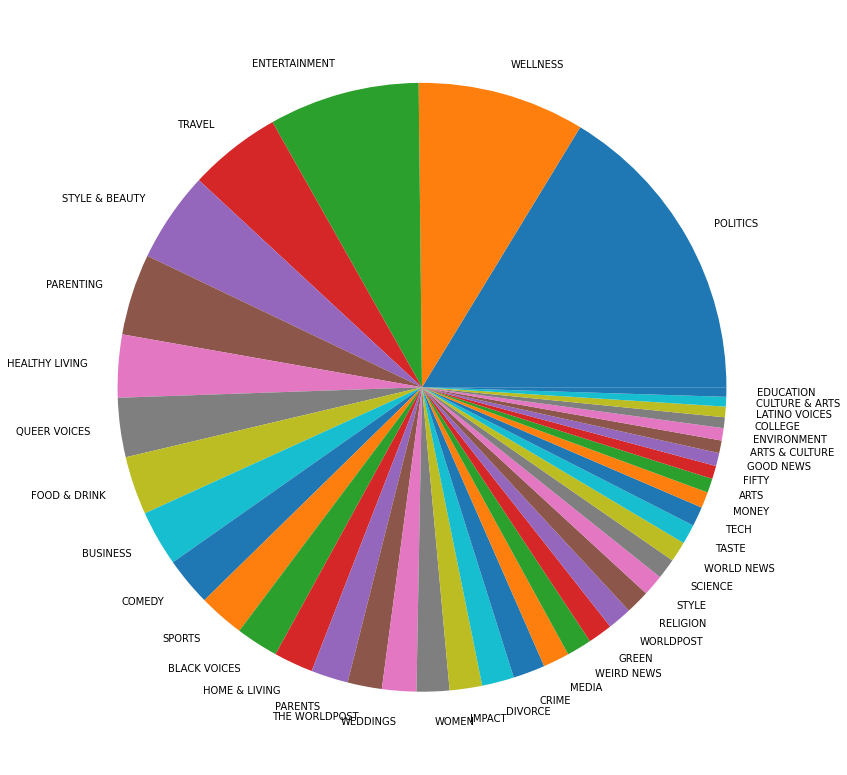

In [37]:
category_dist=dict(original_df['category'].value_counts())
type(category_dist)

fig = plt.figure(figsize =(20, 14)) 
plt.pie(category_dist.values(), labels = category_dist.keys()); 


Selecting predefined number of records from each category and saving it back to a new file with the same input format

In [12]:
num_of_records_for_each_category = 500
data_df = pd.DataFrame(columns=['category', 'headline', 'authors', 'link', 'short_description', 'date'])
for col in original_df['category'].unique():
  print("data sampled in the category ", col)
  indices = original_df[original_df['category']==col].index
  random_items = np.random.choice(indices, num_of_records_for_each_category, False)
  df_temp = original_df.iloc[random_items]
  data_df = pd.concat([data_df, df_temp], ignore_index=True, sort=False)

data sampled in the category  CRIME
data sampled in the category  ENTERTAINMENT
data sampled in the category  WORLD NEWS
data sampled in the category  IMPACT
data sampled in the category  POLITICS
data sampled in the category  WEIRD NEWS
data sampled in the category  BLACK VOICES
data sampled in the category  WOMEN
data sampled in the category  COMEDY
data sampled in the category  QUEER VOICES
data sampled in the category  SPORTS
data sampled in the category  BUSINESS
data sampled in the category  TRAVEL
data sampled in the category  MEDIA
data sampled in the category  TECH
data sampled in the category  RELIGION
data sampled in the category  SCIENCE
data sampled in the category  LATINO VOICES
data sampled in the category  EDUCATION
data sampled in the category  COLLEGE
data sampled in the category  PARENTS
data sampled in the category  ARTS & CULTURE
data sampled in the category  STYLE
data sampled in the category  GREEN
data sampled in the category  TASTE
data sampled in the category 

In [13]:
data_df.head()

,category,headline,authors,link,short_description,date
0,CRIME,Leonel Contreras Guilty: California Teen Convi...,,https://www.huffingtonpost.com/entry/leonel-co...,Leonel Contreras was tried as an adult and wil...,2012-11-04
1,CRIME,Driver Sandwiched By 2 Semi-Trucks Describes H...,Steven Hoffer,https://www.huffingtonpost.com/entry/kaleb-whi...,,2015-01-19
2,CRIME,Person Of Interest Detained After California M...,,https://www.huffingtonpost.com/entry/person-of...,Riverside County sheriff's deputies called the...,2015-12-12
3,CRIME,A Famous Hacker On What It Is Like Being Pursu...,"Quora, ContributorThe best answer to any question",https://www.huffingtonpost.com/entry/a-famous-...,I surrendered to the U.S. Marshals Service aft...,2015-05-19
4,CRIME,Ohio State University Attack Leaves 11 Injured,Willa Frej and Ryan Grenoble,https://www.huffingtonpost.com/entry/ohio-stat...,"Police fatally shot the suspect, OSU student A...",2016-11-28


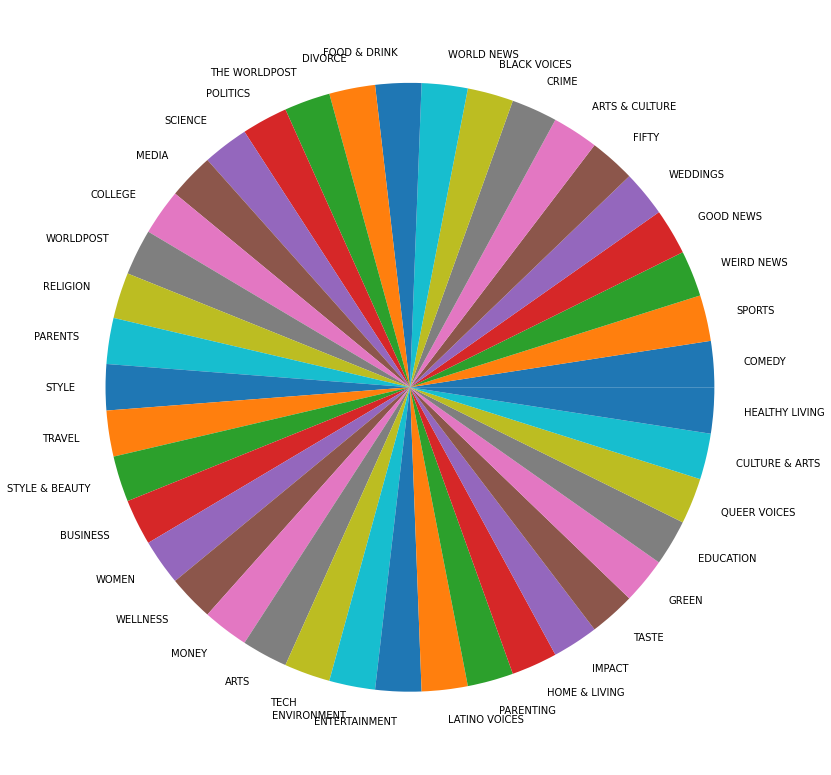

In [38]:
sampled_category_dist=dict(data_df['category'].value_counts())


fig = plt.figure(figsize =(20, 14)) 
plt.pie(sampled_category_dist.values(), labels = sampled_category_dist.keys()); 

**Part 2 - Keywords Extraction**

In this part, we are going to work on the sample dataset. 

Firstly,  we will go over each record in the dataset and access the orignal news article, then we will save the main text by scraping the news. We are going to use beatifulsoup to scrape the articles.

Secondly, after scraping the text of each article, we will implement keyword extraction by the rake library. Then we will have a new column 'key_words'  for each article. This new column will be used in the modelling later.



In [14]:
# converting the dataframe into a list of dictionary
data = data_df.to_dict(orient='records')

In [15]:
len(data)

20500

In [16]:
FROM_RECORDS = 0
TO_RECORDS = 20500
NUM_RECORDS = TO_RECORDS-FROM_RECORDS
NUM_RECORDS

400

In [17]:
data = data[FROM_RECORDS:TO_RECORDS]
print('Number of rows in the data', len(data))

Number of rows in the data 400


In [19]:
def read_article_content(site):
    '''
    Reads all the article text and returns as a string
    '''
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = Request(site,headers=hdr)
    page = urlopen(req)
    soup = BeautifulSoup(page)
#     soup = BeautifulSoup(page, "lxml")

    content = [soup.title.text]
    for div in soup.findAll("div", {"class": "content-list-component yr-content-list-text text"}):
        sentence = '\n' + div.text.strip()
        sentence = sentence.encode("ascii", "ignore").decode()  # To ignore the non-ascii characters in the article.
        sentence = sentence.replace("\"","").replace("{","").replace("}","").replace("...","") # To clean some of the punctuation characters
        content.append(sentence)

    article = ' '.join([str(elem) for elem in content])  
    
    return article


In [20]:
def get_me_keywords(text):
  '''
  Returns upto predifned number of the keywords by using the RAKE algorithm given the text

  '''    
  NUM_PHRASES = 20; # number of phrases in the top ranking
    
  rake = Rake(stopwords= stop_words, punctuations= punctuation_list)
  text_array = text.split('\n')
  rake.extract_keywords_from_sentences(text_array)
    
    
  my_phrases = rake.get_ranked_phrases()

  if len(my_phrases) < NUM_PHRASES:
    NUM_PHRASES = len(my_phrases)
        
  return my_phrases[:NUM_PHRASES]

In [21]:
def validateurl(url):
  '''
  There are some systematic typos in the hyperlinks. 
  This method Validates and returns the correct form of the the hyperlink given in the dataset. 
  '''

  if url.startswith('https://www.huffingtonpost.comhttp://'):
    url = url.replace('https://www.huffingtonpost.com','')
  return url

In [22]:
my_list = []
start_index = 0
interval = 100
for i in range(NUM_RECORDS):
    try:
      url = data[i]['link']
      url = validateurl(url)
      article = read_article_content(url)
      keywords = get_me_keywords(article)
      data[i]["key_words"] = keywords

      if (i > 0) and ((i % interval) == (interval-1)) :
        data_in_box = data[start_index:start_index+interval]
        df_in_box = pd.json_normalize(data_in_box)
        out_filename = str(FROM_RECORDS+start_index)+"_"+str(FROM_RECORDS+i)+".json"
        df_in_box.to_csv (r'/content/drive/My Drive/BigDataAnalyticsAndApplications/Project/dataset/' + out_filename, index = False, header=True)
        print(i, 'is done')
        start_index = i+1


    except:
      print("Something went wrong at ", (FROM_RECORDS+i) )
      data[i]["key_words"] = []
      my_list.append((FROM_RECORDS+i))
      continue

print("Completed")


with open(r'/content/drive/My Drive/BigDataAnalyticsAndApplications/Project/dataset/errors_file.txt', 'a+') as myfile:
    for item in my_list:
        myfile.write("%s\n" % item)



99 is done
Something went wrong at  189
199 is done
299 is done
399 is done
Completed


**Part 3 - Combining all the files into a single one for use. (Final Part)**



In [23]:
data_final = pd.DataFrame(columns=['category', 'headline', 'authors', 'link', 'short_description', 'date','key_words'])
for i in range(0,20500,100):
  start=i 
  end = i+99
  file_name = str(start)+"_"+str(end)+".json"
  full_path = '/content/drive/My Drive/BigDataAnalyticsAndApplications/Project/dataset/'+file_name


  try:
    df = pd.read_csv(full_path)
    data_final = pd.concat([data_final, df], ignore_index=True, sort=False)    
  except:
    print("Something went wrong at the file",file_name)
    continue

Something went wrong at the file 400_499.json
Something went wrong at the file 500_599.json
Something went wrong at the file 600_699.json
Something went wrong at the file 700_799.json
Something went wrong at the file 800_899.json
Something went wrong at the file 900_999.json
Something went wrong at the file 1000_1099.json
Something went wrong at the file 1100_1199.json
Something went wrong at the file 1200_1299.json
Something went wrong at the file 1300_1399.json
Something went wrong at the file 1400_1499.json
Something went wrong at the file 1500_1599.json
Something went wrong at the file 1600_1699.json
Something went wrong at the file 1700_1799.json
Something went wrong at the file 1800_1899.json
Something went wrong at the file 1900_1999.json
Something went wrong at the file 2000_2099.json
Something went wrong at the file 2100_2199.json
Something went wrong at the file 2200_2299.json
Something went wrong at the file 2300_2399.json
Something went wrong at the file 2400_2499.json
Some

In [24]:
data_final.shape

(400, 7)

In [25]:
# To delete any empty keywords in the sampled dataset.
data_final.drop(data_final[data_final['key_words'] == '[]'].index, inplace = True)

In [26]:
data_final.shape

(399, 7)

In [27]:
# Creating the final output file to use
output_filename = 'News_Category.csv'
output_filename = '/content/drive/My Drive/BigDataAnalyticsAndApplications/Project/dataset/'+ output_filename
data_final.to_csv(output_filename, index= False)